# Machine Learning (ML) 
## lecture 12 Basic Text Classification with Movie Reviews

## Text Classification with IMDB Movie Reviews


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. 

This is an example of *binary*—or two-class—classification.  

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). 

Imdb dataset split into 25,000 reviews for training and 25,000 reviews for testing. 

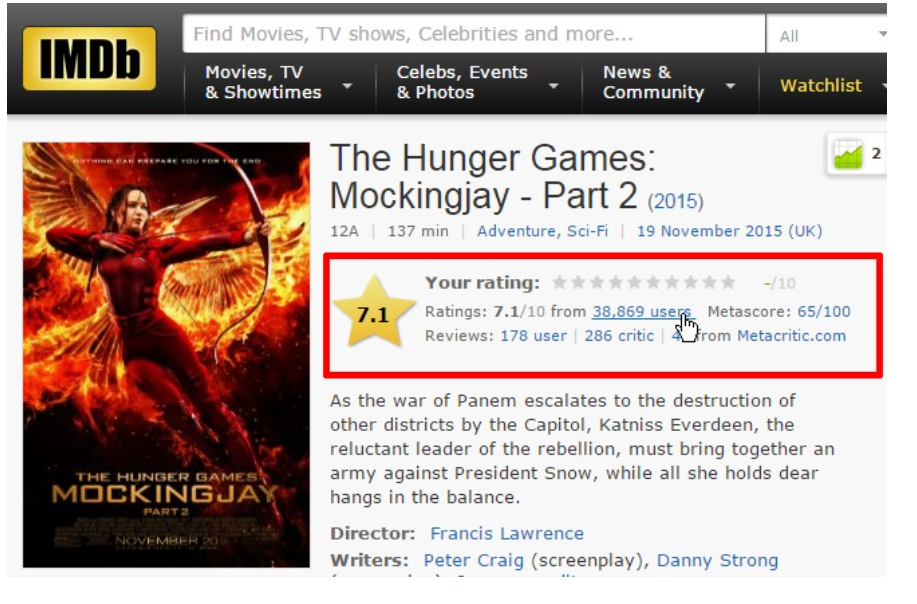

## 1. Setup

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
tf.__version__

'2.7.0'

## 2. Download the IMDB dataset

- The reviews (sequences of words) have been converted to sequences of integers

- `vocal_size` ~ 10,000 most frequently occurring words.

In [2]:
vocal_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocal_size)

## 3. Explore the data 

- Each `y_train, y_test` is an integer value of either `0`(negative) or `1`(positive) review.

In [3]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

print("Test entries: {}, labels: {}".format(len(X_test), len(y_test)))

Training entries: 25000, labels: 25000
Test entries: 25000, labels: 25000


- 첫 샘플 

In [4]:
print(X_train[0])
print('-------')
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
-------
1


- Check the first data : Movie reviews may be different lengths. 

In [5]:
len(X_train[0]), len(X_train[1])

(218, 189)

- The 5 most frequently used words

In [6]:
imdb_get_word_index = {}

for key, value in imdb.get_word_index().items():
    imdb_get_word_index[value] = key
    
for i in range(1, 6):
    print('{}-th word which is used the most frequently = {}'.format(i, imdb_get_word_index[i])) 

1-th word which is used the most frequently = the
2-th word which is used the most frequently = and
3-th word which is used the most frequently = a
4-th word which is used the most frequently = of
5-th word which is used the most frequently = to


- Convert the integers back to words

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [8]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

-  display the text for the first review:

In [9]:
decode_review(X_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 4. Prepare the data

- pad the arrays so they all have the same length,

In [10]:
seq_len = 256
print('Before pad_sequences: ', len(X_train[0]))

Before pad_sequences:  218


In [27]:
X_train = pad_sequences(X_train, maxlen=seq_len, padding = 'pre')
X_test = pad_sequences(X_test, maxlen=seq_len, padding = 'pre')
print('After X_train pad_sequences: ', len(X_train[0]))
print('After X_test pad_sequences: ', len(X_test[0]))

After X_train pad_sequences:  256
After X_test pad_sequences:  256


## 5. Build the model

- Construct a model using the Embedding layer

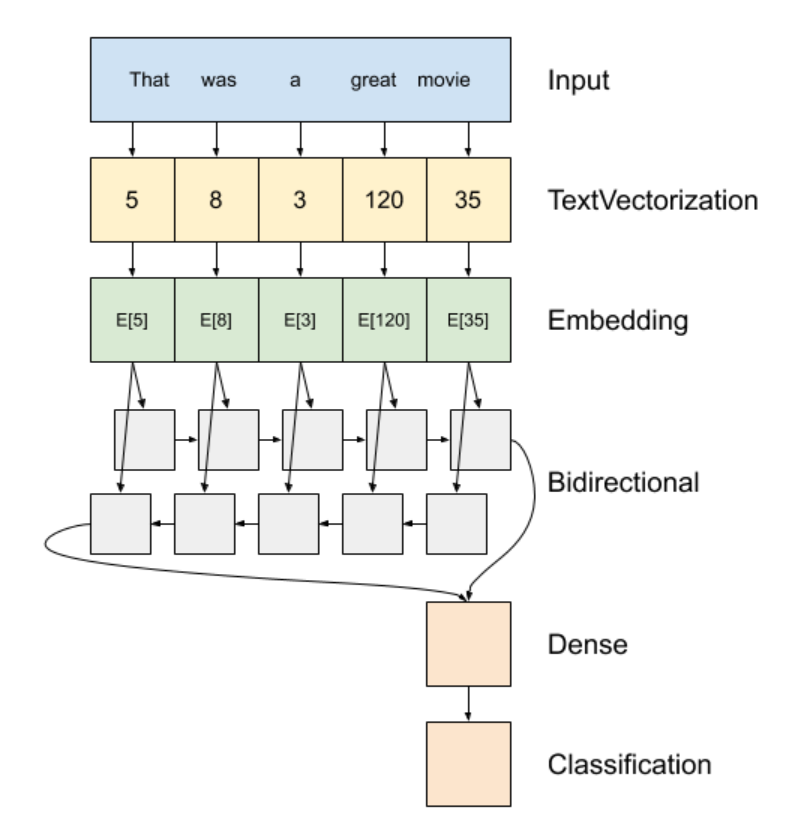

In [12]:
embedding_dim = 64 

- The first layer is an Embedding layer.
- The resulting dimensions are: (batch, sequence, embedding, seq_len).

In [13]:
m1 = Sequential()

m1.add(Embedding(vocal_size, embedding_dim, input_length = seq_len))
m1.add(SimpleRNN(embedding_dim))               
m1.add(Dense(1, activation='sigmoid'))

In [14]:
m2 = Sequential()

m2.add(Embedding(vocal_size, embedding_dim, input_length = seq_len))
m2.add(Bidirectional(LSTM(embedding_dim)))               
m2.add(Dropout(0.2))
m2.add(Dense(embedding_dim, activation = 'relu'))
m2.add(BatchNormalization())
m2.add(Dropout(0.2))
m2.add(Dense(1, activation='sigmoid'))

In [15]:
m3 = Sequential()
m3.add(Embedding(input_dim = vocal_size, output_dim = embedding_dim, input_length = seq_len))
m3.add(Bidirectional(LSTM(embedding_dim, return_sequences = True )))
m3.add(Bidirectional(LSTM(embedding_dim)))
m3.add(Dense(embedding_dim, activation = 'relu'))
m3.add(Dropout(0.5))
m3.add(Dense(1, activation = 'sigmoid'))

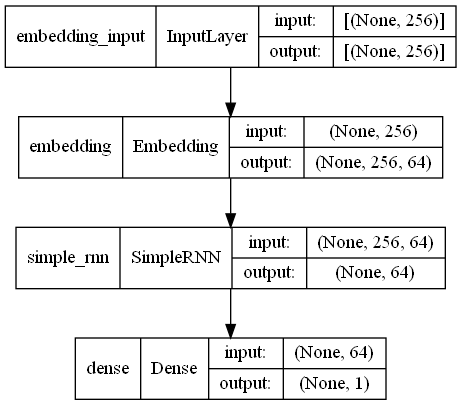

In [16]:
model = m1; plot_model(model, show_shapes=True)

In [17]:
#model = m2; plot_model(model, show_shapes=True)

In [18]:
#model = m3; plot_model(model, show_shapes=True)

In [19]:
model = m1

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [39]:
X_train.shape, y_train.shape

((25000, 256), (25000,))

In [40]:
num_small = 10000
X_train = X_train[:num_small,]
y_train = y_train[:num_small]

## 6. Train the model

notebook cpu: for 10 epoches : Elapsed 421.751 seconds.

In [42]:
import time
start = time.perf_counter()

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split = 0.2, verbose=1)

elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/10
125/125 [==============================] - 36s 282ms/step - loss: 0.0239 - acc: 0.9929 - val_loss: 0.0216 - val_acc: 0.9915
Epoch 2/10
125/125 [==============================] - 37s 296ms/step - loss: 0.0167 - acc: 0.9940 - val_loss: 0.0182 - val_acc: 0.9950
Epoch 3/10
125/125 [==============================] - 41s 325ms/step - loss: 0.0024 - acc: 0.9999 - val_loss: 0.0097 - val_acc: 0.9985
Epoch 4/10
125/125 [==============================] - 50s 400ms/step - loss: 5.5857e-04 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9980
Epoch 5/10
125/125 [==============================] - 42s 336ms/step - loss: 3.0947e-04 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 0.9965
Epoch 6/10
125/125 [==============================] - 41s 327ms/step - loss: 2.4567e-04 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9980
Epoch 7/10
125/125 [==============================] - 44s 355ms/step - loss: 2.0310e-04 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 0.9965
Epoch 8/10
125/125 [===================

## 7. Evaluate the model


In [43]:
X_test.shape, y_test.shape

((25000, 256), (25000,))

In [44]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)

print("Test accuracy: {}".format(test_acurracy))
print("Test loss: {}".format(test_loss))

782/782 [==============================] - 25s 31ms/step - loss: 1.0450 - acc: 0.8047 22s - loss: 1.0399 - - - ETA: 16 - ETA: 7s - loss: 1.0634 - acc: - ETA: 6s - loss: 1.0589 - acc: 0. - ETA: 6s - loss: 1.0571 - acc: 0.802 - ETA: 6s - loss: 1.05 - ETA: 5s - loss: 1.0532 - acc: 0. - - ETA: 2s - loss: 1.0511 - acc: 0. - ETA: 2s - ETA: 0s - loss: 1.0458 
Test accuracy: 0.8046799898147583
Test loss: 1.0449944734573364


In [45]:
# Generate predictions
predictions = model.predict(X_train[0:20])
print(predictions)


[[9.9997437e-01]
 [8.7442859e-06]
 [1.9897489e-04]
 [9.9998474e-01]
 [3.0892802e-04]
 [4.2887846e-06]
 [9.9998951e-01]
 [2.0990226e-06]
 [9.9999142e-01]
 [1.0015908e-05]
 [9.9998605e-01]
 [6.3934647e-05]
 [2.1752841e-05]
 [1.4925316e-06]
 [1.1938051e-04]
 [1.5989141e-05]
 [9.9999392e-01]
 [9.9966526e-01]
 [1.3153195e-06]
 [9.9991345e-01]]


In [46]:
for i in range(2):
  INDEX_FROM=3   # word index offset
  word_to_id = imdb.get_word_index()
  word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
  word_to_id["<PAD>"] = 0
  word_to_id["<START>"] = 1
  word_to_id["<UNK>"] = 2
  word_to_id["<UNUSED>"] = 3

  id_to_word = {value:key for key,value in word_to_id.items()}
  print('=================================================')
  print(f'Sample = {i} | Length = {len(X_test[i])}')
  print('=================================================')
  print(' '.join(id_to_word[id] for id in X_test[i] ))


Sample = 0 | Length = 256
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## 8. Create a graph of accuracy and loss over time

- `model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

- There are four entries: one for each monitored metric during training and validation. 
- We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

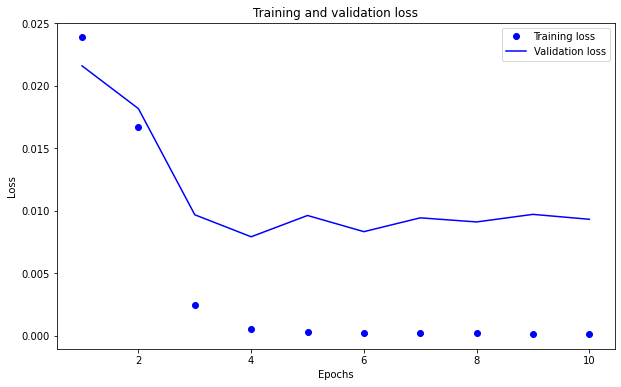

In [48]:
plt.figure(figsize=(10, 6))

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

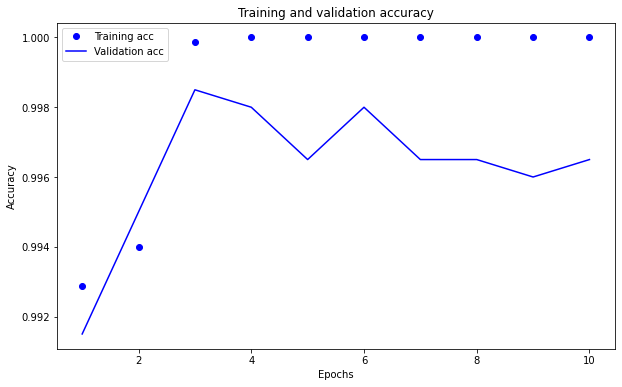

In [49]:
#plt.clf()   # clear figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 9. Model Evaluation : ROC Curve

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_hat = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

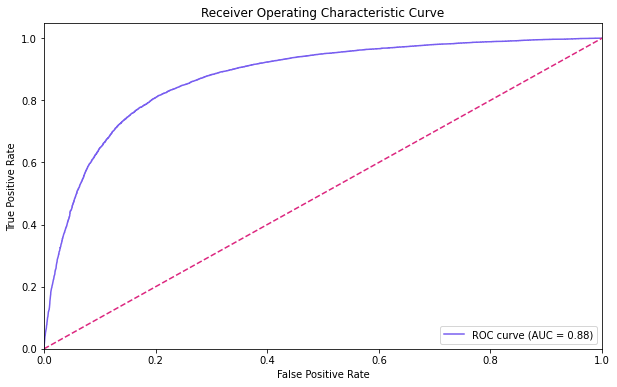

In [51]:
fig = plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='#785ef0', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#dc267f', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.show()

In [52]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
y_pred = np.where(y_hat>=optimal_threshold, 1, 0)
print('Balanced Accuracy Score:',balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Threshold value is: 0.47539678
Balanced Accuracy Score: 0.8051200000000001
[[ 9939  2561]
 [ 2311 10189]]


# Model M3: Stack two or more LSTM layers

### return_sequence : True or False 
return_sequence = False:
- It returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). 

return_sequence = True:
- the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

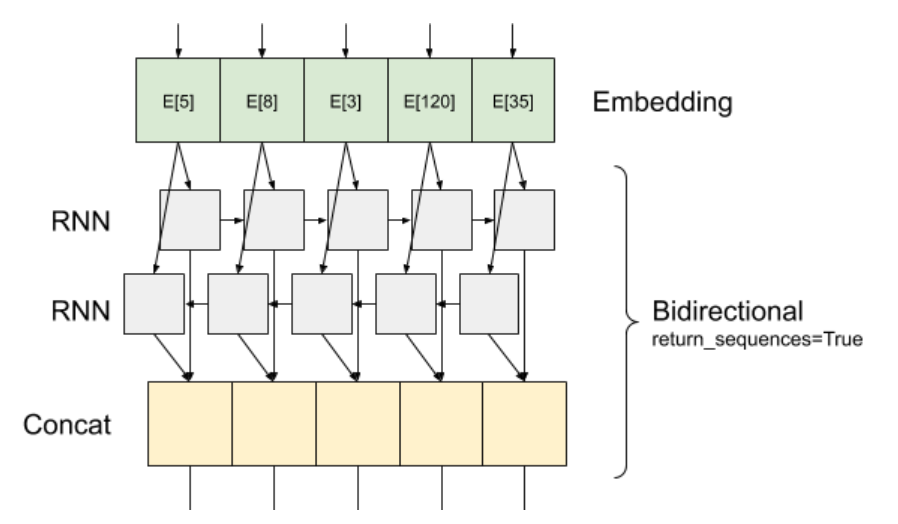